# Experiment 10 - Implementing a Bidirectional Encoder Representation with Transformers (BERT) 

## About the BERT
BERT stands for "Bidirectional Encoder Representation with Transformers". To put it in simple words BERT extracts patterns or representations from the data or word embeddings by passing it through an encoder. The encoder itself is a transformer architecture that is stacked together. It is a bidirectional transformer which means that during training it considers the context from both left and right of the vocabulary to extract patterns or representations.

<!-- ![](./assets/images/BERT-encoder.webp) -->

## Paradigms of Use
BERT uses two training paradigms: Pre-training and Fine-tuning. 

During pre-training, the model is trained on a large dataset to extract patterns. This is generally an unsupervised learning task where the model is trained on an unlabelled dataset like the data from a big corpus like Wikipedia.  

During fine-tuning the model is trained for downstream tasks like Classification, Text-Generation, Language Translation, Question-Answering, and so forth. Essentially, you can download a pre-trained model and then Transfer-learn the model on your data.

## How does BERT work?
BERT makes use of Transformer, an attention mechanism that learns contextual relations between words (or sub-words) in a text. In its vanilla form, Transformer includes two separate mechanisms — an encoder that reads the text input and a decoder that produces a prediction for the task. Since BERT’s goal is to generate a language model, only the encoder mechanism is necessary. The detailed workings of Transformer are described in a paper by Google.

As opposed to directional models, which read the text input sequentially (left-to-right or right-to-left), the Transformer encoder reads the entire sequence of words at once. Therefore it is considered bidirectional, though it would be more accurate to say that it’s non-directional. This characteristic allows the model to learn the context of a word based on all of its surroundings (left and right of the word).

When training language models, there is a challenge of defining a prediction goal. Many models predict the next word in a sequence (e.g. “The child came home from ___”), a directional approach which inherently limits context learning. To overcome this challenge, BERT uses two training strategies:

### Masked LM (MLM)

Before feeding word sequences into BERT, 15% of the words in each sequence are replaced with a [MASK] token. The model then attempts to predict the original value of the masked words, based on the context provided by the other, non-masked, words in the sequence. In technical terms, the prediction of the output words requires:
1. Adding a classification layer on top of the encoder output.
2. Multiplying the output vectors by the embedding matrix, transforming them into the vocabulary dimension.
3. Calculating the probability of each word in the vocabulary with softmax.

<!-- ![](./assets/images/BERT-architecture.webp) -->

The BERT loss function takes into consideration only the prediction of the masked values and ignores the prediction of the non-masked words. As a consequence, the model converges slower than directional models, a characteristic which is offset by its increased context awareness.

### Next Sentence Prediction (NSP)

In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. During training, 50% of the inputs are a pair in which the second sentence is the subsequent sentence in the original document, while in the other 50% a random sentence from the corpus is chosen as the second sentence. The assumption is that the random sentence will be disconnected from the first sentence.

To help the model distinguish between the two sentences in training, the input is processed in the following way before entering the model:

1. A [CLS] token is inserted at the beginning of the first sentence and a [SEP] token is inserted at the end of each sentence.
2. A sentence embedding indicating Sentence A or Sentence B is added to each token. Sentence embeddings are similar in concept to token embeddings with a vocabulary of 2.
3. A positional embedding is added to each token to indicate its position in the sequence. The concept and implementation of positional embedding are presented in the Transformer paper.

<!-- ![](./assets/images/BERT-with-modifications.webp) -->

Source: BERT [Devlin et al., 2018], with modifications

To predict if the second sentence is indeed connected to the first, the following steps are performed:

1. The entire input sequence goes through the Transformer model.
2. The output of the [CLS] token is transformed into a 2×1 shaped vector, using a simple classification layer (learned matrices of weights and biases).
3. Calculating the probability of IsNextSequence with softmax.

When training the BERT model, Masked LM and Next Sentence Prediction are trained together, with the goal of minimizing the combined loss function of the two strategies.

### Special tags for the tokens pre-defined by BERT
BERT takes special tokens during training. Here is a table explaining the purpose of various tokens:
|                                            Token                                            |                        Purpose                       |
|:-------------------------------------------------------------------------------------------:|:----------------------------------------------------:|
| [CLS]                                                                                       |       The first token is always classification       |
| [SEP]                                                                                       |                Separates two sentences               |
| [END]                                                                                       |                   End the sentence.                  |
| [PAD]                                                                                       |    Use to truncate the sentence with equal length.   |
|                                            [MASK]                                           | Use to create a mask by replacing the original word. |

## How to use BERT (Fine-tuning)

Using BERT for a specific task is relatively straightforward:

BERT can be used for a wide variety of language tasks, while only adding a small layer to the core model:

1. Classification tasks such as sentiment analysis are done similarly to Next Sentence classification, by adding a classification layer on top of the Transformer output for the [CLS] token.
2. In Question Answering tasks (e.g. SQuAD v1.1), the software receives a question regarding a text sequence and is required to mark the answer in the sequence. Using BERT, a Q&A model can be trained by learning two extra vectors that mark the beginning and the end of the answer.
3. In Named Entity Recognition (NER), the software receives a text sequence and is required to mark the various types of entities (Person, Organization, Date, etc) that appear in the text. Using BERT, a NER model can be trained by feeding the output vector of each token into a classification layer that predicts the NER label.

In the fine-tuning training, most hyper-parameters stay the same as in BERT training.

## Summary

BERT falls into a self-supervised model. That means, it can generate inputs and labels from the raw corpus without being explicitly programmed by humans. Remember the data it is trained on is unstructured.

BERT was pre-trained with two specific tasks: Masked Language Model and Next sentence prediction. The former uses masked input like “the man [MASK] to the store” instead of “the man went to the store”. This restricts BERT to see the words next to it which allows it to learn bidirectional representations as much as possible making it much more flexible and reliable for several downstream tasks. The latter predicts whether the two sentences are contextually assigned to each other. 

<!-- ![](./assets/images/BERT-overview.webp) -->

## Code

### Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

import transformers
from transformers import AutoModel, BertTokenizerFast

import matplotlib.pyplot as plt

2023-04-20 17:06:38.242756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 17:06:39.769696: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-20 17:06:39.769843: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-20 17:06:39.769855: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

#### Define GPU Here if Available

In [2]:
device = torch.device("cuda")

### Preprocessing

#### Import the Corpus of Raw Text

In [3]:
data = pd.read_csv(r"./assets/data/spam-data.csv")
data.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


### Check the Shape of Data

In [4]:
data.shape

(5572, 2)

#### Check the Way Labels are Distributed

In [5]:
data['label'].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

#### Plot the Bar Plot for the Distribution

<AxesSubplot: >

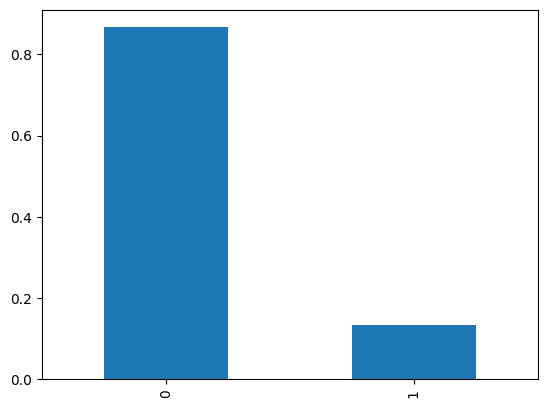

In [6]:
data['label'].value_counts(normalize=True).plot.bar()

### Split the Data into Training, Testing and Validation Sets

#### Train-test Split

In [7]:
XTrain, XTest, yTrain, yTest = train_test_split(data['text'], data['label'], random_state=42, test_size=0.3, stratify=data['label'])

#### Validation Split

In [8]:
XValidationTrain, XValidationTest, yValidationTrain, yValidationTest = train_test_split(
    XTest, 
    yTest, 
    random_state=42, 
    test_size=0.5, 
    stratify=yTest
)

### Download and Import the Pre-trained BERT Model from Huggingface

In [9]:
# Import the BERT-base pretrained model
BERT = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Get the Length of each Sequence of Text and Plot their Distributions

<AxesSubplot: >

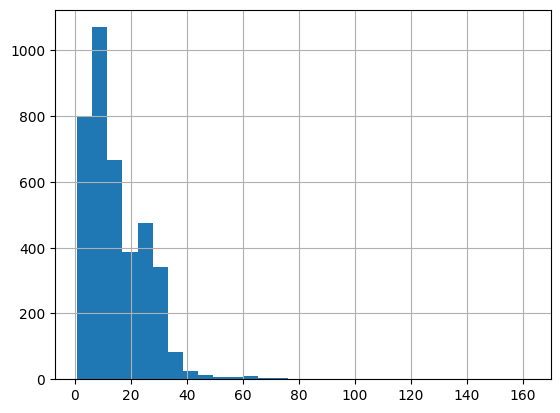

In [10]:
# get length of all the messages in the train set
sequenceLength = [len(sample.split()) for sample in XTrain]

pd.Series(sequenceLength).hist(bins = 30)

### Tokenise and Encode Sequences

In [11]:
# Tokenize and encode sequences in the training set
trainTokens = tokenizer.batch_encode_plus(
    XTrain.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the validation set
validationTokens = tokenizer.batch_encode_plus(
    XValidationTrain.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# Tokenize and encode sequences in the test set
testTokens = tokenizer.batch_encode_plus(
    XValidationTest.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/home/volt/.local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
type(trainTokens)

transformers.tokenization_utils_base.BatchEncoding

### Convert these Lists to Tensors

In [13]:
trainSequenceTensor = torch.tensor(trainTokens['input_ids'])
trainMaskTensor = torch.tensor(trainTokens['attention_mask'])
trainYTensor = torch.tensor(yTrain.tolist())

validationSequenceTensor = torch.tensor(validationTokens['input_ids'])
validationMaskTensor = torch.tensor(validationTokens['attention_mask'])
validationYTensor = torch.tensor(yValidationTrain.tolist())

testSequenceTensor = torch.tensor(testTokens['input_ids'])
testMaskTensor = torch.tensor(testTokens['attention_mask'])
testYTensor = torch.tensor(yValidationTest.tolist())

#### Here're the Created Tensors

In [14]:
trainSequenceTensor, trainSequenceTensor.shape

(tensor([[  101,  3125,   999,  ...,  1037,  3413,   102],
         [  101,  1045,  2123,  ...,     0,     0,     0],
         [  101,  9779,  2232,  ...,     0,     0,     0],
         ...,
         [  101,  2469,  1010,  ...,  1998,  3227,   102],
         [  101,  2498,  2021,  ...,  2253, 11047,   102],
         [  101,  7087,  1012,  ...,  2061,  1045,   102]]),
 torch.Size([3900, 25]))

In [15]:
testSequenceTensor, testSequenceTensor.shape

(tensor([[  101,  4067,  2017,  ...,     0,     0,     0],
         [  101,  6203,  5718,  ...,  2345,  3535,   102],
         [  101,  2073,  2024,  ...,     0,     0,     0],
         ...,
         [  101,  2053,  1012,  ...,  4309,  2489,   102],
         [  101,  1015,  1045,  ...,  1005,  1040,   102],
         [  101,  2524,  2444,  ..., 21472, 21472,   102]]),
 torch.Size([836, 25]))

In [16]:
validationSequenceTensor, validationSequenceTensor.shape

(tensor([[  101,  5003,  2132,  ...,     0,     0,     0],
         [  101, 11948,  2072,  ...,  1012, 20228,   102],
         [  101, 13433,  2139,  ...,  2050,  1012,   102],
         ...,
         [  101,  2053,  3291,  ...,     0,     0,     0],
         [  101,  1998,  2011,  ...,     0,     0,     0],
         [  101,  2002,  2758,  ...,  1055,  5791,   102]]),
 torch.Size([836, 25]))

### Using the Data Loader in PyTorch to Load the Dataset

#### Define Hyper-parameter(s)

In [17]:
batchSize = 16

#### Create Training Tensors

In [18]:
# Wrapping the training tensors
trainingTensor = TensorDataset(trainSequenceTensor, trainMaskTensor, trainYTensor)

# Randomly Sampling the Wrapped Tensor
trainingSampler = RandomSampler(trainingTensor)

# Putting the training sampled data in a data loader
trainingDataLoader = DataLoader(trainingTensor, sampler=trainingSampler, batch_size=batchSize)

In [19]:
type(trainingTensor), type(trainingSampler), type(trainingDataLoader)

(torch.utils.data.dataset.TensorDataset,
 torch.utils.data.sampler.RandomSampler,
 torch.utils.data.dataloader.DataLoader)

#### Now, the same for Validation Tensors

In [20]:
# Wrapping the validation tensors
validationTensor = TensorDataset(validationSequenceTensor, validationMaskTensor, validationYTensor)

# Randomly Sampling the Wrapped Tensor
validationSampler = RandomSampler(validationTensor)

# Putting the training sampled data in a data loader
validationDataLoader = DataLoader(validationTensor, sampler=validationSampler, batch_size=batchSize)

### Construct the BERT Model

In [21]:
# Freeze all the parameters
for parameter in BERT.parameters():
    parameter.requires_grad = False

In [22]:
class BERTArchitecture(nn.Module):
    def __init__(self, bert):
        super(BERTArchitecture, self).__init__()
        
        self.bert = bert 
        
        # Dropout layer
        self.dropout = nn.Dropout(0.1)
      
        # ReLU activation function
        self.relu =  nn.ReLU()

        # Dense layer 1
        self.fullyConnected1 = nn.Linear(768, 512)
      
        # Dense layer 2 (Output layer)
        self.fullyConnected2 = nn.Linear(512, 2)

        # Softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):
        # Pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
        # Input layer
        x = self.fullyConnected1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # Output layer
        x = self.fullyConnected2(x)
      
        # Apply softmax activation
        x = self.softmax(x)

        return x

### Pass the Pre-trained BERT from Huggingface to our Defined Architecture

In [23]:
model = BERTArchitecture(BERT)

#### Push our Model to the Device

In [24]:
model = model.to(device)

### Create an Optimiser

In [25]:
# Optimizer from hugging face transformers
from transformers import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5) 

/home/volt/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Compute Class Weights

In [26]:
weightsList = compute_class_weight(class_weight='balanced', classes=np.unique(yTrain), y=yTrain)

print("Class Weights:", weightsList)

Class Weights: [0.57743559 3.72848948]


#### Convert Class Weights List to Tensor

In [27]:
# Converting list of class weights to a tensor
weights = torch.tensor(weightsList, dtype=torch.float)

# Push to GPU
weights = weights.to(device)

### Define Hyper-parameters to Train

In [28]:
# Define the loss function
crossEntropy  = nn.NLLLoss(weight=weights) 

# Define the number of training epochs
epochs = 10

# Define how many steps before printing an update
trainingStepsUpdate = 20
validationStepsUpdate = 10

### Training the Model - Fine Tuning
Define a function to train the model.

In [29]:
def train():
    model.train()
    totalLoss = 0
  
    # Empty list to save model predictions
    totalPredictions = []
  
    # Iterate over batches
    for step, batch in enumerate(trainingDataLoader):
        # Progress update after every 50 batches.
        if step % trainingStepsUpdate == 0 and not step == 0:
            print('\tBatch {:>3,} of {:>3,}.'.format(step, len(trainingDataLoader)))
        
        # Push the batch to gpu
        batch = [r.to(device) for r in batch]
 
        sent_id, mask, labels = batch
        
        # Clear previously calculated gradients 
        model.zero_grad()        

        # Get model predictions for the current batch
        preds = model(sent_id, mask)

        # Compute the loss between actual and predicted values
        loss = crossEntropy(preds, labels)

        # Add on to the total loss
        totalLoss = totalLoss + loss.item()

        # Backward pass to calculate the gradients
        loss.backward()

        # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()

    # Append the model predictions
    totalPredictions.append(preds)

    # Compute the training loss of the epoch
    averageLoss = totalLoss / len(trainingDataLoader)
  
    # Predictions are in the form of (no. of batches, size of batch, no. of classes). Reshape the predictions in form of (number of samples, no. of classes)
    totalPredictions  = np.concatenate(totalPredictions, axis=0)

    # Returns the loss and predictions
    return averageLoss, totalPredictions

### Evaluating the Model - Using the Validation Set
Define a function to evaluate the model.

In [30]:
def evaluate():
    print("\nEvaluating...")
  
    # Deactivate dropout layers
    model.eval()

    totalLoss = 0
    
    # Empty list to save the model predictions
    totalPredictions = []

    # Iterate over batches
    for step, batch in enumerate(validationDataLoader):
        # Progress update every 50 batches.
        if step % validationStepsUpdate == 0 and not step == 0:
            # Report progress.
            print('\tBatch {:>3,} of {:>3,}.'.format(step, len(validationDataLoader)))

        # Push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            
            # Model predictions
            preds = model(sent_id, mask)

            # Compute the validation loss between actual and predicted values
            loss = crossEntropy(preds,labels)

            totalLoss = totalLoss + loss.item()

            preds = preds.detach().cpu().numpy()

            totalPredictions.append(preds)

    # Compute the validation loss of the epoch
    averageLoss = totalLoss / len(validationDataLoader) 

    # Reshape the predictions in form of (number of samples, no. of classes)
    totalPredictions  = np.concatenate(totalPredictions, axis=0)

    return averageLoss, totalPredictions

### Running the Model to Train and Evaluate
Training and validating the model for 50 epochs.

In [31]:
# Set initial loss to infinite
bestValidationLoss = float('inf')

# Empty lists to store training and validation loss of each epoch
trainingLosses = []
validationLosses = []

# Initialize total time taken to 0
totalTimeTaken = 0

# For each epoch
for epoch in range(epochs):
    print('\nEpoch {:} of {:}'.format(epoch + 1, epochs))
    
    # Train model and record time taken
    startTime = time.time()
    trainingLoss, _ = train()
    trainingTimeTaken = time.time() - startTime

    # Evaluate model and record time taken
    startTime = time.time()
    validationLoss, _ = evaluate()
    validationTimeTaken = time.time() - startTime

    # Save the best model
    if validationLoss < bestValidationLoss:
        bestValidationLoss = validationLoss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation losses
    trainingLosses.append(trainingLoss)
    validationLosses.append(validationLoss)
    
    # Print epoch results and times taken
    print(f'\nTraining Loss: {trainingLoss:.3f}')
    print(f'Training Time Taken: {trainingTimeTaken:.2f} seconds')
    print(f'Validation Loss: {validationLoss:.3f}')
    print(f'Validation Time Taken: {validationTimeTaken:.2f} seconds')

    # Update total time taken
    totalTimeTaken += trainingTimeTaken + validationTimeTaken

# Print total time taken for all epochs
print(f'\nTotal Time Taken: {totalTimeTaken:.2f} seconds')


Epoch 1 of 10
	Batch  20 of 244.
	Batch  40 of 244.
	Batch  60 of 244.
	Batch  80 of 244.
	Batch 100 of 244.
	Batch 120 of 244.
	Batch 140 of 244.
	Batch 160 of 244.
	Batch 180 of 244.
	Batch 200 of 244.
	Batch 220 of 244.
	Batch 240 of 244.

Evaluating...
	Batch  10 of  53.
	Batch  20 of  53.
	Batch  30 of  53.
	Batch  40 of  53.
	Batch  50 of  53.

Training Loss: 0.667
Training Time Taken: 19.93 seconds
Validation Loss: 0.642
Validation Time Taken: 3.82 seconds

Epoch 2 of 10
	Batch  20 of 244.
	Batch  40 of 244.
	Batch  60 of 244.
	Batch  80 of 244.
	Batch 100 of 244.
	Batch 120 of 244.
	Batch 140 of 244.
	Batch 160 of 244.
	Batch 180 of 244.
	Batch 200 of 244.
	Batch 220 of 244.
	Batch 240 of 244.

Evaluating...
	Batch  10 of  53.
	Batch  20 of  53.
	Batch  30 of  53.
	Batch  40 of  53.
	Batch  50 of  53.

Training Loss: 0.623
Training Time Taken: 17.57 seconds
Validation Loss: 0.598
Validation Time Taken: 3.59 seconds

Epoch 3 of 10
	Batch  20 of 244.
	Batch  40 of 244.
	Batch  6

### Using Trained Model to Predict

In [32]:
# Get predictions for test data
with torch.no_grad():
    preds = model(testSequenceTensor.to(device), testMaskTensor.to(device))
    preds = preds.detach().cpu().numpy()

### Check Model's Performance on Testing Data

In [33]:
# model's performance
predications = np.argmax(preds, axis=1)
print(classification_report(testYTensor, predications))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       724
           1       0.58      0.80      0.67       112

    accuracy                           0.90       836
   macro avg       0.77      0.86      0.81       836
weighted avg       0.92      0.90      0.90       836



### Plotting Change in Training and Validation Losses

#### Convert lists to arrays

In [34]:
# Convert trainingLosses into a numpy array
trainingLosses = np.array(trainingLosses)

# Convert validationLosses into a numpy array
validationLosses = np.array(validationLosses)

#### Creating an x-axis

In [35]:
X = np.arange(0, epochs)

In [36]:
X.shape, trainingLosses.shape

((10,), (10,))

#### Plotting losses

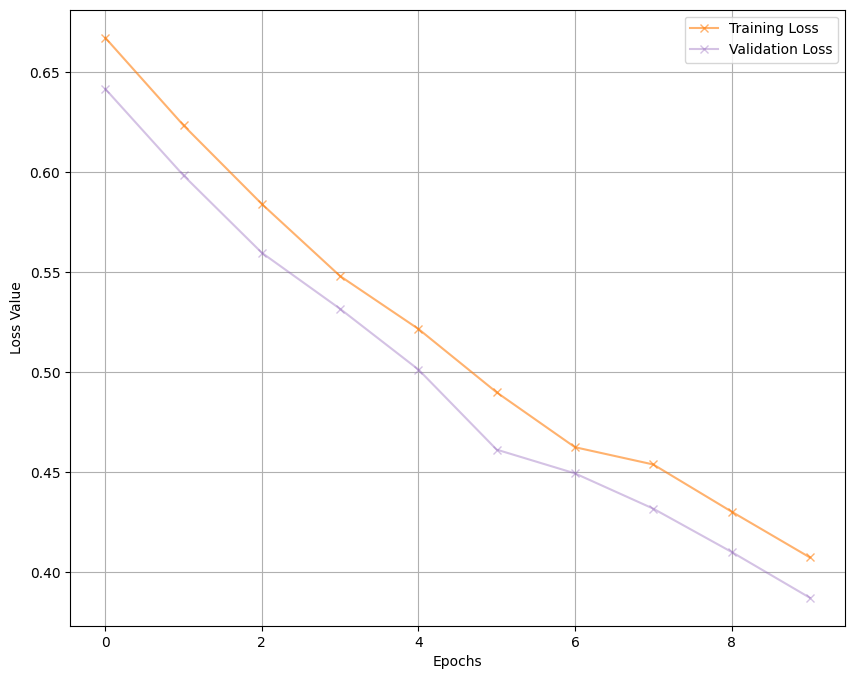

In [37]:
plt.figure(figsize=(10, 8))
plt.grid()

plt.xlabel("Epochs")
plt.ylabel("Loss Value")

plt.plot(X, trainingLosses, label='Training Loss', marker='x', color='C1', alpha=0.6)
plt.plot(X, validationLosses, label='Validation Loss', marker='x', color='C4', alpha=0.4)

plt.legend()
plt.show()

---

## References

<ol>
    <li><a href="https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/">How to use BERT in Kaggle competitions - Reddit Thread</a></li>
    <li><a href="http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">A visual guide to using BERT by Jay Alammar</a></li>
    <li><a href="https://www.analyticsvidhya.com/blog/2019/09/demystifying-bert-groundbreaking-nlp-framework/">Demystifying BERT: Groundbreaking NLP Framework by Mohd Sanad Zaki Rizvi</a></li>
    <li><a href="https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03">BERT for Dummies step by step tutorial by Michel Kana</a></li>
</ol>